In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import argparse
import random
import time
from collections import Counter
from datetime import datetime
%matplotlib inline
np.random.seed(5)
pd.set_option('display.float_format',lambda x : '%.2f' % x)

In [2]:
train = pd.read_csv('./data/Taobao/UserBehavior.csv', sep=',', names=["UserId", "ItemId", "CategoryId", "BehaviorType", "Timestamp"] )

In [3]:
# 按照行为
# train = train.sample(frac=0.7, replace=False, weights=None, random_state=None, axis=0)
all_user = train.UserId.unique()
selected_user = np.random.choice(all_user, int(0.7*len(all_user)))
train = train[train.UserId.isin(selected_user)]

In [8]:
train.describe()

,UserId,ItemId,Timestamp,TimeId,CategoryId
count,50311542.00,50311542.00,50311542.00,50311542.00,50311542.00
mean,507495.93,2580641.04,1511961429.31,4.24,2697785.95
std,294114.09,1487975.73,230083.43,2.65,1462986.38
min,2.00,1.00,1511539200.00,0.00,80.00
25%,253079.00,1296865.25,1511762316.00,2.00,1320293.00
50%,504513.00,2581924.00,1511964766.00,4.00,2672762.00
75%,761628.00,3863114.00,1512179230.00,7.00,4145813.00
max,1018011.00,5163069.00,1512316799.00,8.00,5161669.00


In [9]:
# 2017.11.25 to 2017.12.03
def getTimestamp(value):
    d = datetime.strptime(value, "%Y.%m.%d %H:%M:%S") 
    t = d.timetuple() 
    span = int(time.mktime(t)) 
    print(span)
    return span
    
leftValue = '2017.11.25 00:00:00'
rightValue = '2017.12.04 00:00:00'
span_left = getTimestamp(leftValue)
span_right = getTimestamp(rightValue)

train = train[train['Timestamp'].between(span_left, span_right, inclusive=True)]

1511539200
1512316800


In [10]:
day = 1
min_timestamp = train.Timestamp.min()
time_id = [int(math.floor((t-min_timestamp) / (86400*day))) for t in train['Timestamp']]
train['TimeId'] = time_id

session_id = [str(uid)+'_'+str(tid) for uid, tid in zip(train['UserId'], train['TimeId'])]
train['SessionId'] = session_id
train = train[["SessionId", "UserId", "ItemId", "Timestamp", "BehaviorType",'TimeId', "CategoryId"]]

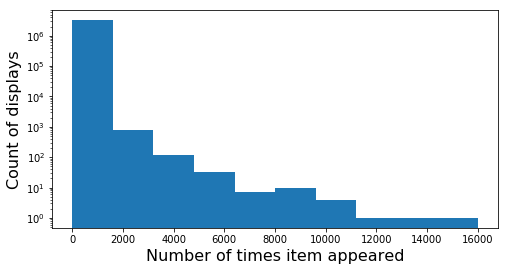

In [11]:
items = train.ItemId.value_counts()
plt.figure(figsize=(8, 4))
plt.hist(items.values, bins=10, log=True)
plt.xlabel('Number of times item appeared', fontsize=16)
plt.ylabel('Count of displays', fontsize=16)
plt.show()

In [12]:
item_cnt = len(train.ItemId.unique())
items = train.ItemId.value_counts()
print(sum(items >200), sum(items >200)/item_cnt)
print(sum(items <10), sum(items<10)/item_cnt)

37155 0.011472032694135322
2477625 0.764995155532419


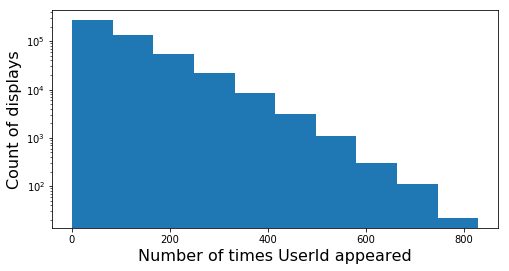

In [13]:
items = train.UserId.value_counts()
plt.figure(figsize=(8, 4))
plt.hist(items.values, bins=10, log=True)
plt.xlabel('Number of times UserId appeared', fontsize=16)
plt.ylabel('Count of displays', fontsize=16)
plt.show()

In [14]:
user_cnt = len(train.UserId.unique())
items = train.UserId.value_counts()
print(sum(items<10)/user_cnt)
print(sum(items<3)/user_cnt, sum(items>=3))
print(sum(items>=40)/user_cnt, sum(items>=40))

0.018869062942463637
0.00019910863689020467 497117
0.7475262260265156 371682


In [15]:
ITEM_MIN = 250
USER_MIN = 20

In [16]:
train = train[train['ItemId'].groupby(train['ItemId']).transform('size')>= ITEM_MIN]

In [17]:
train = train[train['UserId'].groupby(train['UserId']).transform('size')>= USER_MIN]

In [18]:
max_length = 50
train = train[train['SessionId'].groupby(train['SessionId']).transform('size')>1]
train = train[train['SessionId'].groupby(train['SessionId']).transform('size')<max_length]

In [19]:
user_cnt = len(train.UserId.unique())
item_cnt = len(train.ItemId.unique())
cate_cnt = len(train.CategoryId.unique())
session_cnt = len(train.SessionId.unique())
all_cnt = train.shape

print("用户数量：", user_cnt)
print("item数量：", item_cnt)
print("cate数量：", cate_cnt)
print("session数量：", session_cnt)
print("所有行为数", all_cnt[0])

session_cnt_dict = train['SessionId'].value_counts()
user_cnt_dic = train["UserId"].value_counts()
item_cnt_dic = train["ItemId"].value_counts()

print("session平均长度", all_cnt[0]/session_cnt)
print("user平均session个数", session_cnt/user_cnt)
print("user平均行为个数", all_cnt[0]/user_cnt)

用户数量： 247320
item数量： 27364
cate数量： 1339
session数量： 1379790
所有行为数 12238127
session平均长度 8.869557686314584
user平均session个数 5.578966521106259
user平均行为个数 49.48296538896975


In [21]:
Behaviortype_cnt = train["BehaviorType"].value_counts()
print(Behaviortype_cnt)
print(train['TimeId'].value_counts())

pv      11013302
cart      672232
fav       355438
buy       197155
Name: BehaviorType, dtype: int64
7    1591507
8    1550677
6    1355370
1    1340490
5    1338180
0    1304011
4    1270397
2    1267653
3    1219842
Name: TimeId, dtype: int64


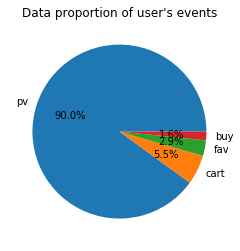

In [22]:
indexes = Behaviortype_cnt.index
values = Behaviortype_cnt.values
plt.subplots(figsize=(4,4))
# Plot
plt.pie(values, labels=indexes,startangle=0, autopct='%.1f%%')
 
plt.title("Data proportion of user's events")
plt.show()

In [23]:
print("-----user的行为-------")
for i,j in Behaviortype_cnt.items():
    print(i, j/user_cnt)
print("\n-----session的行为-----")
for i,j in Behaviortype_cnt.items():
    print(i, j/session_cnt)

-----user的行为-------
pv 44.53057577227883
cart 2.7180656639171925
fav 1.437158337376678
buy 0.7971656153970564

-----session的行为-----
pv 7.981868255314215
cart 0.4871987766254285
fav 0.2576029685676806
buy 0.14288768580726052


In [ ]:
session_cnt_dict.hist(bins=30, figsize=(10,5))

In [ ]:
user_cnt_dic.hist(bins=100, figsize=(10,5))

In [ ]:
item_cnt_dic.hist(bins=100, figsize=(10,5))

In [25]:
user_week = train["TimeId"].groupby(train["UserId"]).unique()
multiweek_dict = {}
for i, v in user_week.items():
    l = len(v)
    if l in multiweek_dict:
        multiweek_dict[l] += 1
    else:
        multiweek_dict[l] = 1
print(multiweek_dict)
# 用户非常活跃

{6: 47002, 5: 50196, 7: 38035, 4: 41703, 8: 26276, 3: 23004, 2: 6897, 9: 13315, 1: 892}


save file

In [24]:
train.head()

,UserID,ItemID,CategoryID,Behaviortype,Timestamp,TimeID,SessionId
269,1000004,2156592,3607361,pv,1511539241,0,1000004_0
270,1000004,1591982,672001,pv,1511539333,0,1000004_0
272,1000004,3999536,4756105,cart,1511571820,0,1000004_0
274,1000004,1591982,672001,pv,1511571841,0,1000004_0
276,1000004,2980887,3607361,cart,1511669671,1,1000004_1


In [25]:
train.to_csv('./data/Taobao/interactions.csv', index=False)

In [ ]:
# split train and test

In [26]:
tmax = train.TimeId.max()
session_max_times = train.groupby('SessionId').TimeId.max()

session_train = session_max_times[session_max_times < tmax].index
session_holdout = session_max_times[session_max_times >= tmax].index
train_tr = train[train['SessionId'].isin(session_train)]
holdout_data = train[train['SessionId'].isin(session_holdout)]

print('Number of train/test: {}/{}'.format(len(train_tr), len(holdout_data)))

Number of train/test: 10687450/1550677


In [27]:
train_tr = train_tr[train_tr['ItemId'].groupby(train_tr['ItemId']).transform('size') >= ITEM_MIN]
train_tr = train_tr[train_tr['SessionId'].groupby(train_tr['SessionId']).transform('size') > 1]

print('Item size in train data: {}'.format(train_tr['ItemId'].nunique()))


Item size in train data: 15780


In [28]:
print('Item size in train data: {}'.format(train_tr['ItemId'].nunique()))

Item size in train data: 15780


In [29]:
train_item_counter = Counter(train_tr.ItemId)
to_predict = Counter(el for el in train_item_counter.elements() if train_item_counter[el] >= ITEM_MIN).keys()
print('Size of to predict: {}'.format(len(to_predict)))

# split holdout to valid and test.
holdout_cn = holdout_data.SessionId.nunique()
holdout_ids = holdout_data.SessionId.unique()
np.random.shuffle(holdout_ids)
valid_cn = int(holdout_cn * 0.5)
session_valid = holdout_ids[0: valid_cn]
session_test = holdout_ids[valid_cn:]
valid = holdout_data[holdout_data['SessionId'].isin(session_valid)]
test = holdout_data[holdout_data['SessionId'].isin(session_test)]

valid = valid[valid['ItemId'].isin(to_predict)]
valid = valid[valid['SessionId'].groupby(valid['SessionId']).transform('size') > 1]

test = test[test['ItemId'].isin(to_predict)]
test = test[test['SessionId'].groupby(test['SessionId']).transform('size') > 1]

Size of to predict: 15418


In [30]:
print('Train set\n\tEvents: {}\n\tSessions: {}\n\tUsers: {}\n\tItems: {}\n\tAvg length: {}'.format(len(train_tr), train_tr.SessionId.nunique(), train_tr.UserId.nunique(),train_tr.ItemId.nunique(),
                                                                                      train_tr.groupby('SessionId').size().mean()))
print('Valid set\n\tEvents: {}\n\tSessions: {}\n\tUsers: {}\n\tItems: {}\n\tAvg length: {}'.format(len(valid), valid.SessionId.nunique(),valid.UserId.nunique(), valid.ItemId.nunique(), valid.groupby('SessionId').size().mean()))
print('Test set\n\tEvents: {}\n\tSessions: {}\n\tUsers: {}\n\tItems: {}\n\tAvg length: {}'.format(len(test), test.SessionId.nunique(), test.UserId.nunique(),test.ItemId.nunique(), test.groupby('SessionId').size().mean()))

Train set
	Events: 8308519
	Sessions: 1078821
	Users: 246561
	Items: 15780
	Avg length: 7.701480597800748
Valid set
	Events: 578016
	Sessions: 75362
	Users: 75362
	Items: 15320
	Avg length: 7.669860141715985
Test set
	Events: 577564
	Sessions: 75337
	Users: 75337
	Items: 15317
	Avg length: 7.666405617425701


In [33]:
train_tr = train_tr.sort_values(by = ["SessionId","Timestamp" ], ascending = [True, True])
valid = valid.sort_values(by = ["SessionId","Timestamp" ], ascending = [True, True])
test = test.sort_values(by = ["SessionId","Timestamp" ], ascending = [True, True])

In [34]:
train_tr.to_csv('./data/Taobao/train.tsv', sep='\t', index=False)
valid.to_csv('./data/Taobao/valid.tsv', sep='\t', index=False)
test.to_csv('./data/Taobao/test.tsv', sep='\t', index=False)

In [35]:
train_tr.head()

,SessionId,UserId,ItemId,Timestamp,BehaviorType,TimeId,CategoryId
269,1000004_0,1000004,2156592,1511539241,pv,0,3607361
270,1000004_0,1000004,1591982,1511539333,pv,0,672001
272,1000004_0,1000004,3999536,1511571820,cart,0,4756105
274,1000004_0,1000004,1591982,1511571841,pv,0,672001
276,1000004_1,1000004,2980887,1511669671,cart,1,3607361


In [26]:
d = datetime.fromtimestamp(1535416283) 
str1 = d.strftime("%Y-%m-%d %H:%M:%S.%f") 
print(str1)

2018-08-28 08:31:23.000000


In [19]:
train.head()

,UserID,ItemID,CategoryID,Behaviortype,Timestamp,TimeID,SessionId
9515559,514449,1168232,64179,pv,1511592314,0,514449_0
83164713,220332,2739898,883960,buy,1512094622,6,220332_6
57405783,883768,224906,4756105,pv,1512049805,5,883768_5
90258724,54334,2787306,2926020,pv,1511940653,4,54334_4
31805677,623249,2571093,1567637,pv,1511603157,0,623249_0
